In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from tools.stats import nbins
from itertools import product
from astropy.io import fits as pyf

from styles import slides

In [3]:
table = genfromtxt("../inputs/tta_bc03/SSAG_catalog.txt", dtype=None, usecols=(40, 41, 42, 43))
u, g, r, i = table.T
names = loadtxt("../inputs/tta_bc03/SSAG_catalog.txt", dtype=np.str, usecols=(0,))

names = array([n+".fits.gz" for n in names])

In [4]:
ug = u-g
gr = g-r
ri = r-i

In [5]:
table = column_stack((ug, gr, ri))

nb_ug = 30#int(ceil(nbins(ug)[0]))
nb_gr = 35#int(ceil(nbins(gr)[0]))
nb_ri = 45#int(ceil(nbins(ri)[0]))

counts, edges = histogramdd(table, (nb_ug, nb_gr, nb_ri))

print "No. bins         :", nb_ug, nb_gr, nb_ri
print "Null bin percent :", round(count_nonzero(counts==0.0)*100./counts.size, 2)
print "Biggest bin count:", counts.max()

No. bins         : 30 35 45
Null bin percent : 99.04
Biggest bin count: 12.0


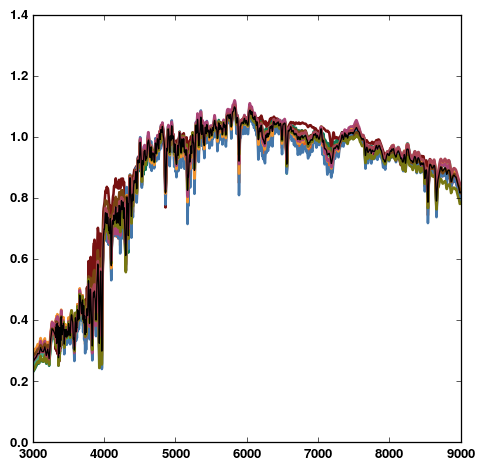

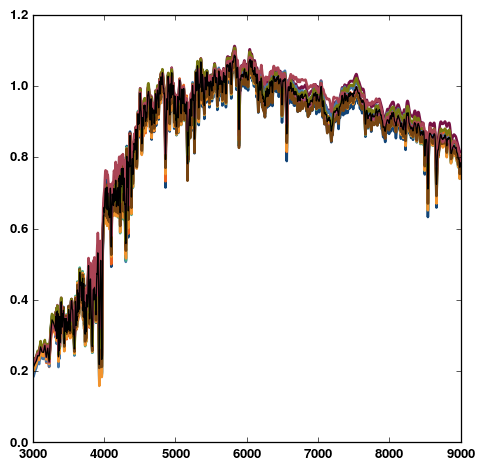

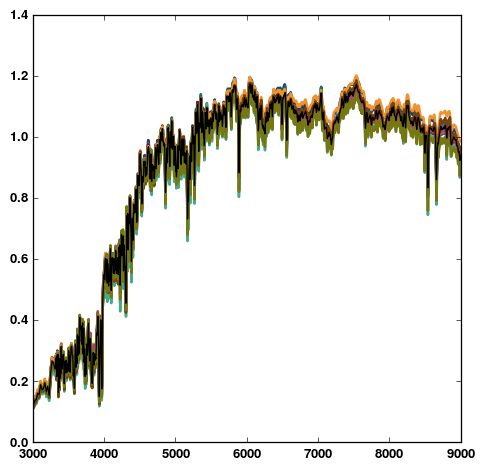

In [9]:
xe, ye, ze = edges

SSAG_binned = []
m = 0
for i, j, k in product(xrange(xe.size-1), xrange(ye.size-1), xrange(ze.size-1)):
    count = int(counts[i, j, k])
    if count==0.0: continue

    if i==xe.size-2: mask = (table[:, 0]>=xe[i])&(table[:, 0]<=xe[i+1])
    else: mask = (table[:, 0]>=xe[i])&(table[:, 0]<xe[i+1])

    if j==ye.size-2: mask = mask&(table[:, 1]>=ye[j])&(table[:, 1]<=ye[j+1])
    else: mask = mask&(table[:, 1]>=ye[j])&(table[:, 1]<ye[j+1])
    
    if k==ze.size-2: mask = mask&(table[:, 2]>=ze[k])&(table[:, 2]<=ze[k+1])
    else: mask = mask&(table[:, 2]>=ze[k])&(table[:, 2]<ze[k+1])
    
    if count!=mask.sum(): print "WARNING: inconsistent bin: ",  count, mask.sum()

    fl = []
    for ised in xrange(count):
        try:
            f = pyf.open("../inputs/SSAG/"+names[mask][ised])

            wl = f[1].data["wavelength"]
            fl.append(f[1].data["flux"]/f[1].data["flux"][2000])
        except IOError:
            print names[mask][ised]
            continue

    if len(fl)==0:
        continue
    elif len(fl)>1:
        mean_fl = array(fl).mean(axis=0)
    else:
        mean_fl = fl[0]

    if len(fl)>10 and m<5:
        m += 1
        fig, ax = subplots(1, 1)
        for ised in xrange(len(fl)): ax.plot(wl, fl[ised])
        ax.plot(wl, mean_fl, "-k", lw=1)

        ax.set_xlim(3000, 9000)

    SSAG_binned.append([mean_fl.size] + list(mean_fl) + [mask.sum()] + list(names[mask]))

In [7]:
# nwl = wl.size
# nbin = len(SSAG_binned)

# f = open("../inputs/SSAG_binned.txt", "w")

# f.write("%10d"%nbin+"\n")
# f.write("%5d"%nwl+nwl*"%12.5e"%tuple(wl)+"\n")

# for i in xrange(len(SSAG_binned)):
#     f.write(("%5d"+nwl*"%12.5e"+"%5d"+SSAG_binned[i][nwl+1]*"%21s"+"\n")%tuple(SSAG_binned[i]))
# f.close()